# Initialize libraries and helper functions

In [ ]:
#import the libraries
%matplotlib inline
import numpy as np
import matplotlib as mat
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import rankdata
import scipy.stats as stats # Adds sub-library to conduct correlation and/or regression

In [ ]:
# toolbox for ranked data

from scipy.stats import rankdata

In [ ]:
# toolbox for bejamini-hochberg correction for multiple comparisons

import statsmodels.stats.multitest as smm

**Small helper functions**
- MAD calculation
- get effect size for difference in medians
- decenter groups of different variability

In [ ]:
# purpose: calculate the MAD
# inputs: data (single column)
# output: Median Absolute Deviation (MAD)

def calc_mad(data):

    return np.nanmedian(abs(data-np.nanmedian(data))) # return the median of each value minus the median of the data

In [ ]:
# purpose: get the original effect sizes of dataset
# inputs: three column dataframe of data
# output: array of difference in medians

def get_effect(group_a,group_b):
    
    return np.median(group_a) - np.median(group_b) # get the effect size that is the difference between medians

In [ ]:
# purpose: decenter data
# input: original data group
# output: data recentered around zero for one group

def decenter(data):
    
    return data - np.median(data) # return the array that is each value subtracted by the median of the dataset

# Plotting

In [ ]:
# Purpose: Plot dot plots for 2 groups of data and lines connecting pairs
# Inputs: dataset is required, but you can also include labels for the 2 groups and colors for the lines and points (if you don't provide them, function will use defaults)
# Outputs: dot plots for 2 groups of data and lines connecting pairs

def slopePlot(data, labels=["CornFlakes", "OatBran"], line_color="gray", point_color=["orange",'blue']):
    import matplotlib.pyplot as plt
    from numpy import array

    dataArr = array(data)
    fig, ax = plt.subplots(figsize=(4, 3))

    x1=0.8
    x2=1.2
    n = dataArr.shape[0]
    for i in range(n):
        ax.plot([x1, x2], [dataArr[i,0], dataArr[i,1]], color=line_color)

        # Plot the points
        ax.scatter(n*[x1-0.01], dataArr[:,0], color=point_color[0], s=25, label=labels[0])
        ax.scatter(n*[x2+0.01], dataArr[:,1], color=point_color[1], s=25, label=labels[1])

    # Fix the axes and labels
    ax.set_xticks([x1, x2])
    _ = ax.set_xticklabels(labels, fontsize='x-large')

    return ax

# **F statistic calculation, big box and two box F statistic omnibus testing**

In [ ]:
# purpose: obtain the F-statistic
# inputs: data frame of (columns, rows)
# output: F-statistic of the dataset

def get_F(df):
    
    grand = np.median(df) # obtain the grand median
   
    across_group = np.sum(len(df)*(abs(df.median() - grand))) # get the sum of the absolute value difference between each groups median and the grand median * the sample size
    
    within_group = np.sum(np.sum(abs(df - df.median()))) # get the sum of the absolute value of each value in each group subtracted by the median of each respective group
    
    F_stat = across_group/within_group # divide the across group differences by the within group differences
    
    return F_stat # return the F-statistic

In [ ]:
# purpose: obtain the big box null distribution for the F-statistic omnibus test of three groups with similar variability
# inputs: dataframe of three columns containing samples from three groups, number of simulations to run
# ouputs: the null f-statistic distribution and the pvalue

def get_bigbox_f(df,boot):
    
    obs = get_F(df) # use the F-statistic function to get the F-statistic for the dataset
    
    groups = list(df.columns) # get the column names
    bigbox = np.concatenate([df[groups[0]],df[groups[1]],df[groups[2]]]) # combine the three different groups into one big box array
    
    nsamples = len(df) # get the sample size for the resamples
    f = np.zeros(boot) # pre-allocate the arrays for collection of the f-statistic matching the number of simulations

    for i in range(boot): # initialize the for loop
        
        resample_a = np.random.choice(bigbox,nsamples) # radnomly resample the first group from the big box
        resample_b = np.random.choice(bigbox,nsamples) # randomly resample a second group from the big box
        resample_c = np.random.choice(bigbox,nsamples) # randomly resample a third group from the big box
    
        resample_df = pd.DataFrame(np.column_stack((resample_a,resample_b,resample_c))) # combine the groups into a dataframe
    
        f[i] = get_F(resample_df) # use the F-statistic function to get the F-statistic for the newly resampled data and store in the pre-allocated array
        
        pval = np.sum(f >= obs) / boot # get the p-value using the original F-statistic and the F-statistic null distribution
    
    return f,pval # return the f statistic null distribution and the pvalue


In [ ]:
# purpose: omnibus testing for the F-statistic when groups have unequal variability
# inputs: dataframe of three columns of different groups, number of simulations to run
# outputs: null distribution of the f-statistic and the pvalue

def get_nbox_f(df,boot):
    
    obs = get_F(df) # use the F-statistic function to get the F-statistic for the dataset
    
    groups = list(df.columns) # get the column names
    
    decentered_a = decenter(df[groups[0]]) # use the decenter function to de-decenter the first group and re-center with the median around zero
    decentered_b = decenter(df[groups[1]]) # use the decenter function to de-decenter the second group and re-center with the median around zero
    decentered_c = decenter(df[groups[2]]) # use the decenter function to de-decenter the third group and re-center with the median around zero
    
    nsamples = len(df) # get the sample size for the resamples
    
    f = np.zeros(boot) # pre-allocate the arrays for collection of the f-statistic matching the number of simulations
    
    for i in range(boot): # initialize the for loop
        
        resample_a = np.random.choice(decentered_a,nsamples) # resample group 1 from the decentered first group
        resample_b = np.random.choice(decentered_b,nsamples) # resample group 2 from the decentered second group
        resample_c = np.random.choice(decentered_c,nsamples) # resample group 3 from the decentered third group
        
        resample_df = pd.DataFrame(np.column_stack((resample_a,resample_b,resample_c))) # put the resampled data into a dataframe
        
        f[i] = get_F(resample_df) # use the F-statistic function to get the F-statistic for the newly resampled data and store in the pre-allocated array
        
    pval = np.sum(f >= obs) / boot # get the p-value using the original F-statistic and the F-statistic null distribution
        
    return f,pval # return the f statistic null distribution and the pvalue
 

# **Big Box and Two Box NHST**

In [ ]:
# purpose: Get the null distribution with a big box model for two group comparisons and pvalue for that comparison
# inputs: group_a, group_b, and the number of simulations to run
# outputs: null distribution of difference between medians and the two sided p-value

def bigbox_twosided(group_a,group_b,boot):
    
    bigbox = np.concatenate([group_a,group_b]) # combine the two data groups into a single array for a big box
    
    nsamples_a = len(group_a) # get the sample size which is the length of one of the groups
    nsamples_b = len(group_b) # get the sample size which is the length of one of the groups

    delta_med =np.zeros(boot) # pre-allocate the array to contain the difference between medians for each iteration
    
    obs = get_effect(group_a,group_b) # get the original effect size that is the difference between medians of the two groups

    
    for i in range(boot): # initialize the for loop
        
        resample_a = np.random.choice(bigbox,nsamples_a) # resample the first group from the big box
        resample_b = np.random.choice(bigbox,nsamples_b) # resample the second group from the big box
        
        delta_med[i] = np.median(resample_a) - np.median(resample_b) # get the difference between medians of the resampled groups and store them in the pre-allocated array
    
    if obs < 0: # if the observed effect size is negative do the following p-value procedure
        pval = (np.sum(delta_med <= obs) + np.sum(delta_med >= -obs)) / boot # get the sum of all indices where the difference between arrays were as or more extreme than observed
        
    else: # if the observed effect size is positive do the following p-value procedure
        pval = (np.sum(delta_med >= obs) + np.sum(delta_med <= -obs)) / boot # signs are flipped from above to account for positive p-value
        
    return delta_med, pval

In [ ]:
# purpose: Get the null distribution with a two box model for two group comparisons and pvalue for that comparison
# inputs: group_a, group_b, and the number of simulations to run
# outputs: null distribution of difference between medians and the two sided p-value

def twobox_twosided(group_a,group_b,boot):
    
    obs = get_effect(group_a,group_b) # get the original observed difference in medians
    
    decentered_a = decenter(group_a) # decenter the first group using the decenter function
    decentered_b = decenter(group_b) # decenter the second group using the decenter function
    
    nsamples = len(decentered_a) # get the sample size using one of the decentered dataset groups
    delta_med =np.zeros(boot) # pre-allocate the array to store the difference in medians at each iteration
    
    
    for i in range(boot): # initialize for loop. 
        
        resample_a = np.random.choice(decentered_a,nsamples) # radnomly resample the first group from the decentered group 1
        resample_b = np.random.choice(decentered_b,nsamples) # radnomly resample the second group from the decentered group 2
        
        delta_med[i] = np.median(resample_a) - np.median(resample_b) # obtain and store the difference in medians between the resampled groups
    
    if obs < 0:
        pval = (np.sum(delta_med <= obs) + np.sum(delta_med >= -obs)) / boot
        
    else:
        pval = (np.sum(delta_med >= obs) + np.sum(delta_med <= -obs)) / boot
        
    return delta_med, pval

# **Confidence interval for difference in medians**

In [ ]:
# purpose: get confidence intervals for two groups
# inputs: data from dataframe of two sample groups, defined confidence interval, number of simulations
# output: null distribution of data for all three comparisons

def two_ci(group_a, group_b,ci,boot):
    
    obs = get_effect(group_a,group_b) # get the orgiginal difference in medians
    
    nsamples = len(group_a)
    
    ci_dist = np.zeros(boot)
    
    for i in range(boot):
        
        resample_a = np.random.choice(group_a,nsamples)
        resample_b = np.random.choice(group_b,nsamples)
      
        ci_dist[i] = np.median(resample_a) - np.median(resample_b)

    if ci == 95: # do the following CI procedure if confidence interval is defined as 95%
        ci_sorted = np.sort(ci_dist)
        lower = ci_sorted[np.int64((boot*0.025)-1)]
        upper = ci_sorted[np.int64((boot*0.975)-1)]
        ci_lower = (2*obs) - upper
        ci_upper = (2*obs) - lower
    
    elif ci == 99: # do the following procedure if the confidence interval is defined at 99%
        ci_sorted = np.sort(ci_dist)
        lower = ci_sorted[np.int64((boot*0.005)-1)]
        upper = ci_sorted[np.int64((boot*0.995)-1)]
        ci_lower = (2*obs) - upper
        ci_upper = (2*obs) - lower
    
        
    return ci_dist, (ci_lower, ci_upper)

#**NHST and confidence intervals with ranks**

## ranked NHST

In [ ]:
# purpose: function for obtaining the null distribution of difference in average ranks of two datasets
# inputs: group_a and group_b and the number of simulations to run
# output: the observed value (difference in ranks of original data), the null rank distribution, and the two-sided pvalue


def get_rank_nhst(group_a, group_b,boot):
  
  ranks = np.zeros(boot) # pre-allocate array to store the difference in ranks between resampled groups for each iteration

  comb_rank = rankdata(np.concatenate((group_a,group_b)))

  obs = np.mean(comb_rank[0:len(group_a)]) - np.mean(comb_rank[len(group_a):])
  
  for i in range(boot):
    
    # randomly resample the data from the big box model (combined groups) to generate a new group_a sample
    resample_a = np.random.choice(np.concatenate((group_a,group_b)),len(group_a))
    
    # randomly resample the data from the big bix model (combined groups) to generate the group_b sample
    resample_b = np.random.choice(np.concatenate((group_a,group_b)),len(group_b))
    
    # rank the new randomly resampled data
    comb_rank_i = rankdata(np.concatenate((resample_a,resample_b)))
    
    # get the ranks for the group_a from the ranked randomly resampled data
    a_ranks = comb_rank_i[0:len(group_a)]
    
    # get the ranks for the placebo group from the ranked randomly resampled data
    b_ranks = comb_rank_i[len(group_a):]
    
    # get the difference in average ranks between groups and store in the pre-allocated array
    ranks[i] = np.mean(a_ranks) - np.mean(b_ranks)

  pval = (np.sum(ranks >= obs) + np.sum(ranks <= -obs)) / boot
  
  return obs, ranks, pval


## ranked confidence intervals

In [ ]:
# purpose: function for obtaining the 95 or 99% confidence interval of difference in average ranks of two datasets
# inputs: group_a and group_b, the confidence interval, and the number of simulations to run
# output: the observed value (difference in ranks of original data), the ci rank distribution, and the confidence interval

def ranked_ci(group_a, group_b,ci,boot):
  
  comb_rank = rankdata(np.concatenate((group_a,group_b)))

  obs = np.mean(comb_rank[0:len(group_a)]) - np.mean(comb_rank[len(group_a):])    
        
  ci_dist = np.zeros(boot)
    
  for i in range(boot):
        
      rank_resample_a = np.random.choice(comb_rank[0:len(group_a)],len(group_a))
      rank_resample_b = np.random.choice(comb_rank[len(group_a):],len(group_b))
      
      ci_dist[i] = np.mean(rank_resample_a) - np.mean(rank_resample_b)

  if ci == 95: # do the following CI procedure if confidence interval is defined as 95%
      ci_sorted = np.sort(ci_dist)
      lower = ci_sorted[np.int64((boot*0.025)-1)]
      upper = ci_sorted[np.int64((boot*0.975)-1)]

    
  elif ci == 99: # do the following procedure if the confidence interval is defined at 99%
      ci_sorted = np.sort(ci_dist)
      lower = ci_sorted[np.int64((boot*0.005)-1)]
      upper = ci_sorted[np.int64((boot*0.995)-1)]
  
  ci_lower = (2*obs) - upper
  ci_upper = (2*obs) - lower
    
        
  return obs,ci_dist, (ci_lower, ci_upper)

#**Comparing proportions**

In [ ]:
# purpose: obtain the expected table from a contingency table
# inputs: a contingency table that has the predictors in columns and the outcomes in rows - very important that this is the input shape
# outputs: the expected table from original data 

def get_expected(table):
    
    total_predictor_a = table[0][0] + table[1][0] # get the sum of the first column that is predictor_a
    total_predictor_b = table[0][1] + table[1][1] # get the sum of the second column that is predictor_b

    total_outcome_a = table[0][0] + table[0][1] # get the sum of the first row that is outcome_a
    total_outcome_b = table[1][0] + table[1][1] # get the sum of the second row that is outcome_b
    
    expected = np.array([[(total_outcome_a / (total_predictor_a + total_predictor_b))*total_predictor_a,(total_outcome_a / (total_predictor_a + total_predictor_b))*total_predictor_b], # get the expected values and put them directly into a new table
          [(total_outcome_b / (total_predictor_a + total_predictor_b))*total_predictor_a,(total_outcome_b / (total_predictor_a + total_predictor_b))*total_predictor_b]])

    return expected # return expected table

In [ ]:
# purpose: get the chi abs from any observed and expected tables
# inputs: obesrved (can be resampled) and expected (obtained using the get_expected function) tables
# output: the new chi abs value

def get_chi(observed,expected):
    
    return np.sum(abs(observed - expected) / expected)

## **chi abs omnibus testing**

In [ ]:
# purpose: perform omnibus testing for contingency tables
# inputs: outcomes_dict = the outcome strings to use when counting numbers in each category, table = the original contingency table, boot = number of simulations to run
# output: observed chi abs, null distribution of chi, one-sided p-value

def chi_omnibus(outcomes_dict,table,boot):
    
    total_predictor_a = table[0][0] + table[1][0] # get the sum of the first column that is predictor_a
    total_predictor_b = table[0][1] + table[1][1] # get the sum of the second column that is predictor_b

    total_outcome_a = table[0][0] + table[0][1] # get the sum of the first row that is outcome_a
    total_outcome_b = table[1][0] + table[1][1] # get the sum of the second row that is outcome_b
    
    expected = get_expected(table) # get the expected table from the original contingency table
    obs = get_chi(table,expected) # get the original chi value from the original table and expected table 
    
    bigbox = np.array([outcomes_dict[0]]*total_outcome_a + [outcomes_dict[1]]*total_outcome_b) # create a big box combining the original outcomes into a single array (matches original total sample size)
    
    chi = np.zeros(boot) # pre-allocate array
    
    for i in range(boot):
        shuffled_big_box = np.random.choice(bigbox, len(bigbox)) # resample with replacement from the big box - can add in if eflif statement for this if needed
            
        predictor_a_resample = shuffled_big_box[:total_predictor_a] # collect a random sample for predictor_a
        predictor_b_resample = shuffled_big_box[total_predictor_a:] # collect a random sample for predictor_b
            
        # count the number of corresponding outcomes for each predictor and place them into a contingency table where the outcome values are the rows and the predictor values are the columns
        resampled_table = np.array([[np.sum(predictor_a_resample ==outcomes_dict[0]), np.sum(predictor_b_resample==outcomes_dict[0])],
                                    [np.sum(predictor_a_resample ==outcomes_dict[1]), np.sum(predictor_b_resample==outcomes_dict[1])]])
        
        # calculate chi using the get_chi function using the newly resampled contingency table and the expected
        chi[i] = get_chi(resampled_table,expected)
    
    p = np.sum(chi >= obs) / boot
    
    return obs,chi,p


## **relative risk calculation and confidence interval**

this doesn't work yet, but it is supposed to be faster



```
def rr_nhst(predictor,table,boot):
    
    rr_obs = get_rr(predictor,table)
    rr_null = np.zeros(boot)
    resample_table = np.zeros([2,2])
    
    for i in range(boot):
        
        resample_table[0][0] = np.random.binomial( (table[0][0]+table[1][0]), ((table[0][0] + table[0][1]) / np.sum(table)) )
        resample_table[1][0] = resample_table[0][0] - table[0][0]+table[1][0]
    
        resample_table[0][1] = np.random.binomial( (table[0][1] + table[1][1]), ((table[0][0] + table[0][1]) / np.sum(table)) )
        resample_table[1][1] = resample_table[0][1] - table[0][1] + table[1][1]
        
        rr_null[i] = get_rr(predictor,resample_table)
    
    p = (np.sum(rr_null >= rr_obs) + np.sum(rr_null <= 1/rr_obs)) / boot
    
    return rr_null, p
```



In [ ]:
# purpose: returns the relative risk of a specified predictor variable from a contingency table
# inputs: predictor can be [0] indicates the first column is the test factor or [1] indicates the second column is the test factor, IMPORTANT: table is a contingency table with outcomes in rows and predictors in columns
# output: the relative risk of a specified predictor

def get_rr(predictor,table):
    
    if predictor == 0: # reads which predictor will be used to calculate relative risk
        
        rr = (table[0][0] / (table[0][0]+table[1][0])) / (table[0][1] / (table[0][1]+table[1][1])) # calculates the rr by dividing the probability of outcome in the first predictor group by the second predictor group

    elif predictor == 1:
        rr = (table[0][1] / (table[0][1]+table[1][1])) / (table[0][0] / (table[0][0]+table[1][0])) # calculates the rr by dividing the probability of outcome in the second predictor group by the first predictor group

    return rr

In [ ]:
# purpose: conducts NHST for the relative risk of observed contingency table
# inputs: predictor can be [0] indicates the first column is the test factor or [1] indicates the second column is the test factor, IMPORTANT: table is a contingency table with outcomes in rows and predictors in columns
#         observed is the observed table. Table is a  2x2 contingency table with outcomes in rows and predictors in columns
#         outcomes_dict is the array of strings that will serve as the outcomes variable (e.g., 'survived','did not survive')
#         boot is the number of bootrap interations to complete in the for loop for NHST

def rr_nhst(predictor,observed,outcomes_dict,boot): 
    bigbox = np.array(((observed[0][0] + observed[0][1])*[outcomes_dict[0]]) + (observed[1][0] + observed[1][1])*[outcomes_dict[1]] ) # creates a big box where rows are summed (to ignore predictor variable association with outcomes)
    rr_null = np.zeros(boot) #  pre-allocates array for storing null rr values
    table = np.zeros([2,2]) # pre-allocates randomly resampled contingency tables

    obs = get_rr(predictor,observed) # get the original observed effect size using the specified predictor 


    for i in range(boot):
        resample_pred_a = np.random.choice(bigbox,observed[0][0]+observed[1][0]) # resample from the big box model to the sample size of the first predictor group
        resample_pred_b = np.random.choice(bigbox, observed[0][1]+observed[1][1]) # resample from the big box model to the sample size of the second predictor group
      
        # all counts stored in a 2x2 randomly resampled contingency table
        table[0][0] = np.sum(resample_pred_a == outcomes_dict[0]) # count the number of samples that are in the first predictor group that match the first outcome
        table[1][0] = np.sum(resample_pred_a ==outcomes_dict[1]) # count the number of samples that are in the first predictor group that match the second outcome
        table[0][1] = np.sum(resample_pred_b ==outcomes_dict[0]) # count the number of samples that are in the second predictor group that match the first outcome
        table[1][1] = np.sum(resample_pred_b ==outcomes_dict[1]) # count the number of samples that are in the second predictor group that match the second outcome
    
        rr_null[i] = get_rr(0,table) # store the relative risk for the randomly resampled contingency table

    if obs < 1: # if the observed effect size is less than 1 do the following p-value procedure
        p = (np.sum(rr_null <= obs) + np.sum(rr_null >= 1/obs)) / boot
        
    else: # if the observed effect size is greater than 1 do the following p-value procedure
        p = (np.sum(rr_null >= obs) + np.sum(rr_null <= 1/obs)) / boot   
  
    
    return rr_null, p

In [ ]:
# purpose: get the relative risk confidence interval
# inputs: the dictionary of outcomes, specified predictor for calcularing relative risk, confidence interval, observed contingency table, and number of simulations
# ouputs: observed relative risk, rr confidence interval distribution, rr confidence intervals


def get_rr_ci(outcomes_dict,predictor,ci,table,boot):
    
    rr_obs = get_rr(predictor,table)
    
    rr = np.zeros(boot)

    predictor_alist = np.array([outcomes_dict[0]]*table[0][0] + [outcomes_dict[1]]*table[1][0])
    predictor_blist = np.array([outcomes_dict[0]]*table[0][1] + [outcomes_dict[1]]*table[1][1])
    
    for i in range(boot):
        
        predictor_a_resample = np.random.choice(predictor_alist,len(predictor_alist))
        predictor_b_resample = np.random.choice(predictor_blist,len(predictor_blist))
    
        # count the number of corresponding outcomes for each predictor and place them into a contingency table where the outcome values are the rows and the predictor values are the columns
        resampled_table = np.array([[np.sum(predictor_a_resample ==outcomes_dict[0]), np.sum(predictor_b_resample==outcomes_dict[0])],
                                [np.sum(predictor_a_resample ==outcomes_dict[1]), np.sum(predictor_b_resample==outcomes_dict[1])]])
        
        rr[i] = get_rr(predictor,resampled_table)
    
    rr_sorted = np.sort(rr)

    
    if ci ==95:
        
        lower = rr_sorted[np.int64((boot*0.025)-1)]
        upper = rr_sorted[np.int64((boot*0.975)-1)]
    
    elif ci == 99:
        
        lower = rr_sorted[np.int64((boot*0.005)-1)]
        upper = rr_sorted[np.int64((boot*0.995)-1)]        

    rr_lower = np.exp(2*np.log(rr_obs) - np.log(upper))
    rr_upper = np.exp(2*np.log(rr_obs) - np.log(lower))

  
    return rr_obs, rr,(rr_lower, rr_upper)

**Example**

Data from the UCLA PEERS program [publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8108502/pdf/cbe-20-ar11.pdf). Power can also be calculated using the code in the power for relative risk section.

In this example, the number of PEERS students who went into doctoral programs after graduation (n = 46 our of 141) were compared to the number of students from a non-PEERS control group that went into doctoral programs (n = 17 our of 141). We want to determine whether students in the PEERS program have a significantly higher likelihood of matriculating into PhD programs that control matched students who were not in PEERS.

In [ ]:
observed = np.array([[46,17],[141-46,141-17]])
obs = get_rr(0,observed)
obs

2.7058823529411766

In [ ]:
observed

array([[ 46,  17],
       [ 95, 124]])

NHST

In [ ]:
boot_nhst = 1000
outcomes_dict = ['PhD','nPhD']
predictor = 0

rr_null, p = rr_nhst(predictor,observed,outcomes_dict,boot_nhst)
p

0.001

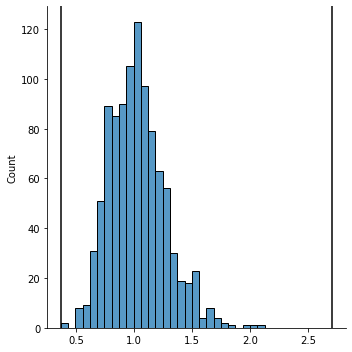

In [ ]:
ax = sns.displot(data = rr_null)
plt.axvline(obs, color = 'k')
plt.axvline(1/obs, color = 'k')

Confidence interval

In [ ]:
ci = 95
boot_nhst = 1000
outcomes_dict = ['PhD','nPhD']
predictor = 0

rr_obs, rr,interval = get_rr_ci(outcomes_dict,predictor,ci,observed,boot_nhst)

95% Confidence interval = (1.5196187242932693, 4.353502291218556)


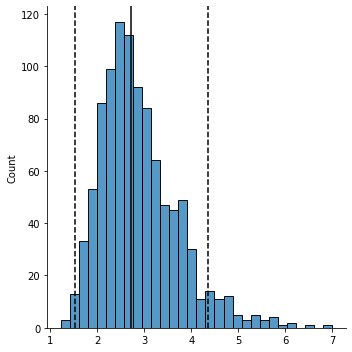

In [ ]:
ax = sns.displot(data = rr)
plt.axvline(interval[0], color = 'k',linestyle = '--')
plt.axvline(interval[1], color = 'k', linestyle = '--')
plt.axvline(rr_obs, color = 'k')
print('95% Confidence interval =',interval)

# Correlation

In [ ]:
# purpose: calculate the pearson or spearman correlation null distribution
# inputs: test type, data frame of shape x,y, the column to shuffle the data,number of simulations
# ouputs: observed correlation,null distribution of the correlation, the two-sided cut-offs for the pvalues

def corr_nhst(test,df,shuffle,boot):
    
    col = df.columns[1]
    
    
    if test =='spear':
      obs,_ = stats.spearmanr(df[df.columns[0]], df[df.columns[1]])
    
    elif test =='pear':
      obs,_ = stats.pearsonr(df[df.columns[0]], df[df.columns[1]])

    corr = np.zeros(boot)
    
    for i in range(boot):
        
        shuffled = np.random.choice(shuffle,len(shuffle),replace=False) # shuffle x
        
        if test == 'spear':
            corr[i],_ = stats.spearmanr(shuffled,df[col]) # use the spearman correlation for ranked correlation coefficient 
        
        elif test == 'pear':
            corr[i],_ = stats.pearsonr(shuffled,df[col]) # use the pearson correlation for standard correlation coefficient
    

    if obs < 0: # if the observed effect size is negative do the following p-value procedure
        pval = (np.sum(corr <= obs) + np.sum(corr >= -obs)) / boot # get the sum of all indices where the difference between arrays were as or more extreme than observed
        
    else: # if the observed effect size is positive do the following p-value procedure
        pval = (np.sum(corr >= obs) + np.sum(corr <= -obs)) / boot # signs are flipped from above to account for positive p-value

    

    
    return obs,corr, pval

In [ ]:
def corr_ci(test,df,ci,boot):

    col = df.columns
    
    if test == 'spear':
        obs,_ = stats.spearmanr(df[col[0]],df[col[1]])
        
    elif test == 'pear':
        obs,_ = stats.pearsonr(df[col[0]],df[col[1]])
    

    ci_dist = np.zeros(boot)
    
    for i in range(boot):
        
        resample = df.sample(len(df),replace = True)
        
        if test == 'spear':
            ci_dist[i],_ = stats.spearmanr(resample[col[0]],resample[col[1]])
        
        elif test == 'pear':
            ci_dist[i],_ = stats.pearsonr(resample[col[0]],resample[col[1]])
    
    
    if ci == 95: # do the following p-range procedure if significance is defined as 95%
        ci_sorted = np.sort(ci_dist)
        lower = ci_sorted[np.int64((boot*0.025)-1)]
        upper = ci_sorted[np.int64((boot*0.975)-1)]
    
    elif ci == 99: # do the following procedure if the significance is defined as 99%
        ci_sorted = np.sort(ci_dist)
        lower = ci_sorted[np.int64((boot*0.005)-1)]
        upper = ci_sorted[np.int64((boot*0.995)-1)]
        
    ci_lower = (2*obs) - upper
    ci_upper = (2*obs) - lower
    
    return ci_dist, (ci_lower, ci_upper)

# Regression

## Ordinary Least Squares (OLS)

## Orthogonal

# Power Analyses
the purpose of power analysis is to determine how often the study would find a difference between groups or relationship between variables using the design employed.

steps for calculating power:


```
1. create a phantom world (make up a defined dataset)
2. choose the across and within group differences (effect size)
3. randomly resample from the manufactured dataset 
4. apply the same measure as in the actual study (e.g., difference in medians) and calculate statistical significance
5. repeat 10,000x and determine the percentage of pvalues under the alpha cut-off 
```



###Two group comparison

In [ ]:
# example of a power function to run using the bigbox_twosided function
# key component here is creating a randomly resampled world (re-creating the groups) prior to running nhst in each iteration
# purpose: This function will either complete retrospective or prospective power analysis on a two-group dataset
# inputs: - alpha :    the desired alpha cut-off
#         - groups :   groups a and b
#         - factor:    the factor to be used to multiply the sample size by. If factor = 1, retrospective analysis will be done. if factor > 1 prospective
#         - boot_nhst: the number of bootstrapped resamples to do in NHST
#         - boot_p :   the number of power studies to run for power analysis

def get_power_twogroup(alpha,group_a,group_b,factor,boot_nhst,boot_p):
    
    if factor <=1: 
        for i in range(boot_p):
        
            new_a = np.random.choice(group_a,len(group_a)) # resample the first group from the from the first group (two box model)
            new_b = np.random.choice(group_b,len(group_b)) # resample the second group from the second group (two box model)
        
            _,pvals[i] = bigbox_twosided(new_a,new_b,boot_nhst)
    else:
        
        for i in range(boot_p):
        
            new_a = np.random.choice(group_a,np.int64(len(group_a)*factor)) # resample the first group from the from the first group (two box model)
            new_b = np.random.choice(group_b,np.int64(len(group_b)*factor)) # resample the second group from the second group (two box model)
        
            _,pvals[i] = bigbox_twosided(new_a,new_b,boot_nhst)
    
    return pvals, (np.sum(pvals <= alpha)) / boot_p

**Example for retrospective power analysis**

uses data from the LS40 ephemeral and permanent plant species diversity data

In [ ]:
group_a = np.array([34,51,20,47,22,19,24,18,33,45,36,42,30,25,44,33,47,35,51,15,24,13,25,32,49,28,37,17,13,32,24,18,22])
group_b = np.array(group_a) + 10 # add 10 to each value in the ephemeral plant species array to create a phantom permanent plant species array

data = pd.DataFrame({'Ephemeral species': group_a, 'Permanent species':group_b})

<Axes: >

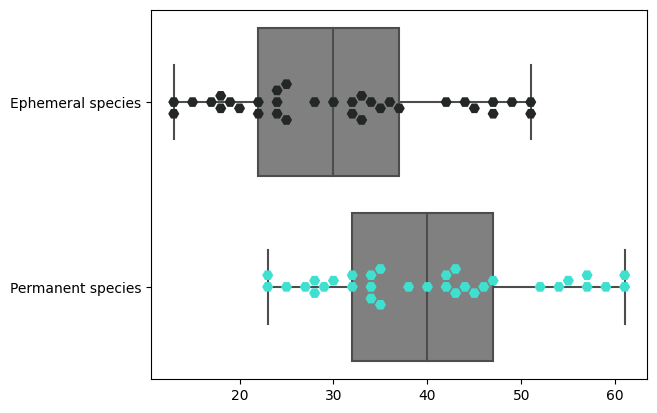

In [ ]:

sns.swarmplot(data = data,palette='dark:turquoise',orient = 'h',size = 8,marker = 'H')
sns.boxplot(data = data, orient = 'h', color = 'grey')


In [ ]:
alpha = 0.01
boot_nhst = 1000
boot_p = 100
factor = 1
pvals = np.zeros(boot_p)

pvals,power = get_power_twogroup(alpha,group_a,group_b,factor,boot_nhst,boot_p)

Power = 0.22


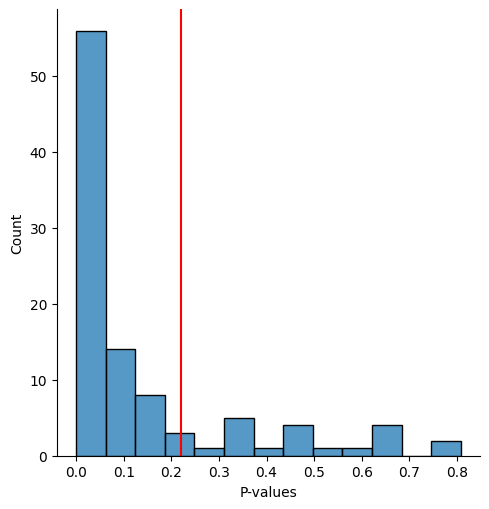

In [ ]:
ax=sns.displot(pvals) #graphs histogram of all the relative risks found
plt.axvline(power, color="red")  #plots observed relative risk
ax.set(xlabel="P-values", ylabel="Count")  #labels axis
print("Power =", power)

**Example for prospective power analysis**

the goal here is to find the sample size that will provide at least 80% power

In [ ]:
group_a = np.array([34,51,20,47,22,19,24,18,33,45,36,42,30,25,44,33,47,35,51,15,24,13,25,32,49,28,37,17,13,32,24,18,22])
group_b = np.array(group_a) + 10 # add 10 to each value in the ephemeral plant species array to create a phantom permanent plant species array


boot_nhst = 1000
boot_p = 100

alpha = 0.01
factor = 1 # start with factor of zero
power = 0
pvals = np.zeros(boot_p)

while power < 0.8:
    
    factor +=0.25 # first loop will have a factor of sample size * 1.25 rounded to the nearest whole number
    
    pvals,power = get_power_twogroup(alpha,group_a,group_b,factor,boot_nhst,boot_p)
    
    if power > 0.8:
        break
        
print('Ephemeral sample size',np.int64(len(group_a)*factor))
print('Permanent sample size',np.int64(len(group_b)*factor))
print('Power',power)

Ephemeral sample size 90
Permanent sample size 90
Power 0.9


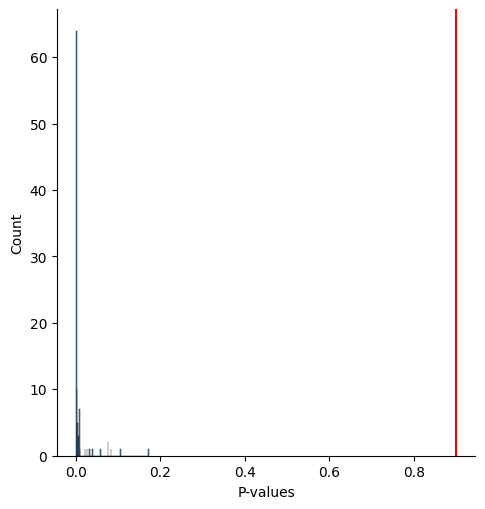

In [ ]:
ax=sns.displot(pvals) #graphs histogram of all the relative risks found
plt.axvline(power, color="red")  #plots observed relative risk
ax.set(xlabel="P-values", ylabel="Count")  #labels axis

### Relative risk

In [ ]:
# power function adapted from My-Thuan and written by RG
# key component here is creating a randomly resampled world (re-creating the groups) prior to running nhst in each iteration

def power_rr(predictor,observed,outcomes_dict,boot_p,boot_nhst):
    pvals=np.zeros(boot_p) #creates empty array to hold all of the pvalues
    
    for i in range(boot_p):  #iterates 100 times
        pred_a_outcome_a = np.random.binomial(np.sum(observed[:,0]), observed[0,0]/np.sum(observed[:,0]))  #randomly samples from total first predictor population size 
        pred_a_outcome_b = np.sum(observed[:,0]) - pred_a_outcome_a
        
        pred_b_outcome_a = np.random.binomial(np.sum(observed[:,1]), observed[0,1]/np.sum(observed[:,1]))  #randomly samples from the second predictor population size
        pred_b_outcome_b = np.sum(observed[:,1]) - pred_b_outcome_a
        
        phantom_obs = np.array([[pred_a_outcome_a,  pred_b_outcome_a], [pred_a_outcome_b, pred_b_outcome_b]])  #assigns values to phantom 2x2 matrix
        
        _,pvals[i]=rr_nhst(0,phantom_obs,outcomes_dict,boot_nhst)  #does NHST and collects all 100 pvalues
    
    return pvals

**Example**

Data from the UCLA PEERS program [publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8108502/pdf/cbe-20-ar11.pdf). Power can also be calculated using the code in the power for relative risk section

In [ ]:
observed = np.array([[46,17],[141-46,141-17]])
obs = get_rr(0,observed)
obs

2.7058823529411766

In [ ]:
observed

array([[ 46,  17],
       [ 95, 124]])

In [ ]:

boot_nhst = 1000
outcomes_dict = ['PhD','nPhD']
predictor = 0
boot_p = 100

pvals = power_rr(predictor,observed,outcomes_dict,boot_p,boot_nhst)


In [ ]:
pvals

array([0.   , 0.008, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   ,
       0.   , 0.005, 0.   , 0.01 , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002,
       0.003, 0.   , 0.002, 0.   , 0.   , 0.   , 0.002, 0.   , 0.   ,
       0.002, 0.   , 0.   , 0.001, 0.   , 0.003, 0.   , 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.02 , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.017,
       0.   , 0.   , 0.   , 0.   , 0.003, 0.   , 0.   , 0.   , 0.001,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.006, 0.   , 0.   , 0.   , 0.   , 0.001, 0.   ,
       0.027])

Power =  1.0


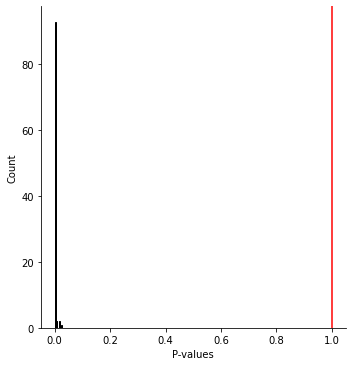

In [ ]:
power=(np.sum(pvals<=.05))/100
ax=sns.displot(pvals) #graphs histogram of all the relative risks found
plt.axvline(power, color="red")  #plots observed relative risk
ax.set(xlabel="P-values", ylabel="Count")  #labels axis
print("Power = ", power)

# Bayesian Analysis